## EDA

In [2]:
import sys,os,re,pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_ingestion import fetch_data,convert_to_ts,engineer_features

In [179]:
data_dir = os.path.join('data','cs-train')

In [92]:
df = fetch_data(data_dir)
df.head(3)

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28


In [93]:
# There are some bad values, particularly the price column & customer_id
df.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


In [94]:
# Aggregate raw data & show top countries with highest revenue  
top_countries = df.groupby('country').sum().sort_values(by='price',ascending = False).head(10)
print(f'List of top countries: {list(top_countries.index)}')

List of top countries: ['United Kingdom', 'EIRE', 'Germany', 'France', 'Norway', 'Spain', 'Hong Kong', 'Portugal', 'Singapore', 'Netherlands']


In terms of revenue & view, the UK market is very dominate

In [95]:
top_countries[['price','times_viewed']].\
rename(columns={'price':'total_revenue','times_viewed':'total_view'}).T

country,United Kingdom,EIRE,Germany,France,Norway,Spain,Hong Kong,Portugal,Singapore,Netherlands
total_revenue,3.521514e+06,107069.21,49271.821,40565.14,38494.75,16040.99,14452.57,13528.67,13175.92,12322.8
total_view,3.725703e+06,111636.00,112618.000,83124.00,7881.00,19573.00,2635.00,14195.00,3042.00,39619.0


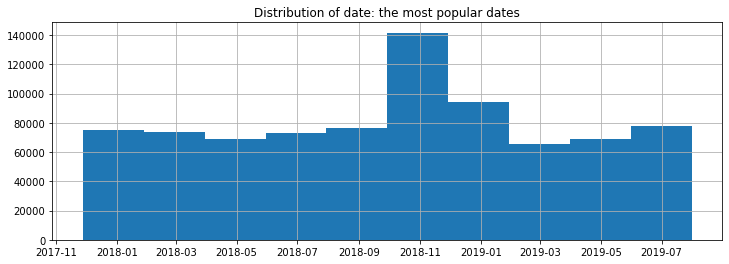

In [97]:
plt.figure(figsize=(12,4))
df.invoice_date.hist();
plt.title('Distribution of date: the most popular dates');

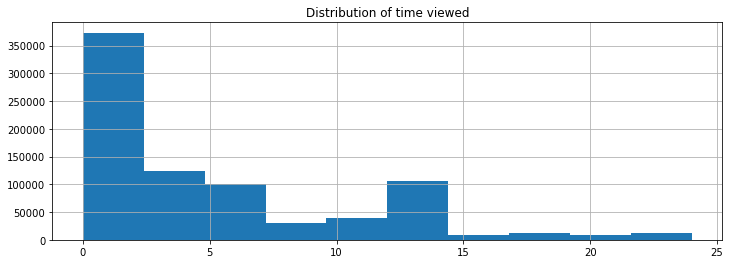

In [98]:
plt.figure(figsize=(12,4))
df.times_viewed.hist()
plt.title('Distribution of time viewed');

## Building Model & Flask app API

First, we decided to use supervised learning models to predict the revenue. We will be predicting the total revenue of the next 30 days as a single prediction. To capture potential seasonality, we added previous revenue, invoice & views as predictors. The corresponding `X` & `y` are prepared in `engineer_features()`. Below we have a quick look at what the `X` & `y` looks like, using the UK market as an example.

In [12]:
country = 'United Kingdom'

df_uk = convert_to_ts(df,country)
X,y,dates = engineer_features(df_uk)

df_ts = X.copy()
df_ts['y'] = y
df_ts['date'] = pd.to_datetime(dates)
df_ts.head(3)

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,y,date
0,13281.12,13281.12,13281.12,13281.12,0.0,5.50000,461.500000,173959.95,2017-11-29
1,26504.09,26504.09,26504.09,26504.09,0.0,9.62069,916.275862,160736.98,2017-11-30
2,39445.59,39445.59,39445.59,39445.59,0.0,14.10000,1393.833333,147795.48,2017-12-01


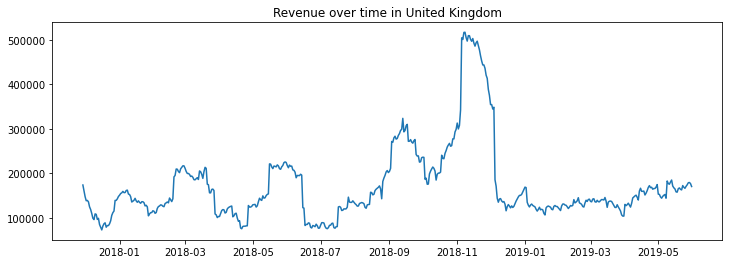

In [13]:
plt.figure(figsize=(12,4))
plt.title(f'Revenue over time in {country}')
plt.plot(df_ts.date,df_ts.y);

In [14]:
df_ts.corr().style.background_gradient().set_caption('Heat map')

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views,y
previous_7,1.000000,0.794352,0.528782,0.349225,0.083892,0.404959,0.505290,0.182032
previous_14,0.794352,1.000000,0.751633,0.473383,0.095394,0.545932,0.688107,0.158251
previous_28,0.528782,0.751633,1.000000,0.665345,0.139064,0.640910,0.846793,0.145133
previous_70,0.349225,0.473383,0.665345,1.000000,0.386260,0.377575,0.602048,0.188104
previous_year,0.083892,0.095394,0.139064,0.386260,1.000000,-0.042110,0.120163,0.152978
recent_invoices,0.404959,0.545932,0.640910,0.377575,-0.042110,1.000000,0.910733,0.570238
recent_views,0.505290,0.688107,0.846793,0.602048,0.120163,0.910733,1.000000,0.491414
y,0.182032,0.158251,0.145133,0.188104,0.152978,0.570238,0.491414,1.000000


Then, several popular regression models are trained on the UK dataset and compared using `model_compare()`. The pipeline featuring liner regression with elastic net serves as a base model. Random forest (`rf`) pipeline proves to be the best performing, with lowest RMSE on test set, but takes the longest time to train, due to the ensemble nature of the model. Gradient boosted tree (`gbt`) pipeline comes in second in RMSE, and takes less time to train per fit than random forest, but due to the amount of tunable paramters, the training time can be much higher in total if we choose to do a more thorough grid serach.

We choose random forest for the next section

In [3]:
from model import model_compare
model_compare_df = model_compare(data_dir,country = 'United Kingdom')

Ingesting data
Training scaler->lr
Training scaler->sgd
Training scaler->svr
Training scaler->rf
Training scaler->gbt
Training finished! Total training time 57s


In [4]:
model_compare_df\
    .style\
    .bar(color='lightblue', subset=['test_rmse'], align='zero')\
    .bar(color='lightblue', subset=['total_time'], align='zero')\
    .bar(color='lightblue', subset=['avg_time'], align='zero')\
    .set_caption('Model comparison')

,pipeline,test_rmse,total_time,avg_time,best_params
0,scaler->lr,52949.785299,2.762000,0.110480,"{'lr__alpha': 0.005623413251903491, 'lr__l1_ratio': 0.5, 'lr__max_iter': 10000}"
1,scaler->sgd,53733.867326,3.350491,0.013402,"{'sgd__alpha': 0.0001, 'sgd__l1_ratio': 0.0, 'sgd__learning_rate': 'invscaling', 'sgd__max_iter': 200, 'sgd__penalty': 'elasticnet'}"
2,scaler->svr,46926.593599,1.230000,0.015375,"{'svr__C': 100.0, 'svr__gamma': 1.0, 'svr__kernel': 'poly'}"
3,scaler->rf,19744.673636,10.818748,0.169043,"{'rf__max_depth': 9, 'rf__min_samples_split': 4, 'rf__n_estimators': 25}"
4,scaler->gbt,23782.773889,38.423687,0.120074,"{'gbt__learning_rate': 0.03162277660168379, 'gbt__max_depth': 6, 'gbt__min_samples_split': 8, 'gbt__n_estimators': 100}"


Random forest models are built for each market and housed in a flask app. Models for each market are then trained using `model_train()`. The whole pipeline will automattically ingest all raw data in `data_dir`, engineer features, train the model, and save trained model & log. 

In [5]:
from model import model_train, model_load, model_predict
# train the models & load all data & models in the memory
model_train(data_dir)

... loading ts data from files
... start training
... saving model: models\sl-all-0_1.joblib
... saving model: models\sl-eire-0_1.joblib
... saving model: models\sl-france-0_1.joblib
... saving model: models\sl-germany-0_1.joblib
... saving model: models\sl-hong_kong-0_1.joblib
... saving model: models\sl-netherlands-0_1.joblib
... saving model: models\sl-norway-0_1.joblib
... saving model: models\sl-portugal-0_1.joblib
... saving model: models\sl-singapore-0_1.joblib
... saving model: models\sl-spain-0_1.joblib
... saving model: models\sl-united_kingdom-0_1.joblib


Next we will unit test the model and API with the `run-tests.py` script, and shows an example how to use the API.

In [6]:
# start the flask app
# !python app.py
# run all unit tests
!python run-tests.py

... test flag on

...........
----------------------------------------------------------------------
Ran 11 tests in 124.429s

OK



... subseting data
... subseting countries
... loading ts data from files
... start training
... saving test version of model: models\test-united_kingdom-0_1.joblib
... loading ts data from files
... loading ts data from files
2018-01-05


In [7]:
import requests
from ast import literal_eval

port = 8080
# Predict API example
query_data = ('all','2018','01','05')
request_json = {'query':query_data,'type':'dict','mode':'test'}
r = requests.post(f'http://127.0.0.1:{port}/predict',json=request_json)
print(literal_eval(r.text))

[178528.60817502515]


In [8]:
# Train API example
request_json = {'query':data_dir,'type':'dict','mode':'test'}
r = requests.post(f'http://127.0.0.1:{port}/train',json=request_json)
print(r.text)

true



In [15]:
# Logging API example
file_name = 'united_kingdom-train-test.log'
r = requests.get(f'http://127.0.0.1:{port}/logs/{file_name}')
print(r.text)

In [10]:
# the save_pickle flag allows to save all data and models in a pickele file to speed up loading
all_data, all_models = model_load(save_pickle=True)

... loading ts data from files
Pickle file saved.


We will randomly make some predictions and check out the log

In [12]:
import random
from model import model_predict

In [104]:
for i in range(10):
    country = random.choice(['all','eire','united_kingdom'])
    start_dt = str(all_data[country]['dates'][0])
    end_dt = str(all_data[country]['dates'][-1])
    dt_range = pd.date_range(start_dt,end_dt,freq='1D')
    date = random.choice(dt_range)
    model_predict(country,str(date.year),str(date.month),str(date.day),all_models=None,test=False,from_pickle=True)

2019-04-01
2018-12-21
2018-07-17
2018-02-06
2019-02-19
2018-10-14
2018-06-20
2019-01-27
2019-03-18
2018-09-16


In [173]:
log_file = os.path.join('logs','predict-2020-6.log')
with open(log_file) as f:
    log = f.read()
log_ = log.replace('\n\n','\t').split('\t')
log_df = pd.DataFrame(columns=log_[0].split(','))
for i in range(0,len(log_)-2):
    log_df.loc[i] =  log_[i+1].split(',')

In [175]:
log_df.tail(5)

,unique_id,timestamp,y_pred,y_proba,country,target_date,model_version,runtime
8,3d61bdac-5cc7-435c-8a21-be769f9943c0,1592232685,[203764.31676448],None,united_kingdom,2018-10-14,0.2,000:00:00
9,6be5a910-72c7-442f-8c0f-43c415d586ee,1592232685,[4049.91950788],None,eire,2018-06-20,0.2,000:00:00
10,c9ecc48d-6565-480c-9fde-f30740103780,1592232685,[123466.00730507],None,united_kingdom,2019-01-27,0.2,000:00:00
11,ad852da5-5849-44d9-b426-f4db64a86095,1592232685,[1872.05504214],None,eire,2019-03-18,0.2,000:00:00
12,3f3d3eab-5643-4bcd-8d20-03ec09e96ceb,1592232685,[242734.15912834],None,united_kingdom,2018-09-16,0.2,000:00:00


Here, we have a quick look at the random forest's built-in feature importance to have a better understand how to model performs.

In [24]:
show_importance('all')

,feature,importance
5,recent_invoices,0.512349
3,previous_70,0.184020
2,previous_28,0.104906
1,previous_14,0.075084
4,previous_year,0.065793
6,recent_views,0.041848
0,previous_7,0.015999


Here is a plot that shows the actual revenue vs prediction for each market. Note the performance metric shown here is for the whole data set.

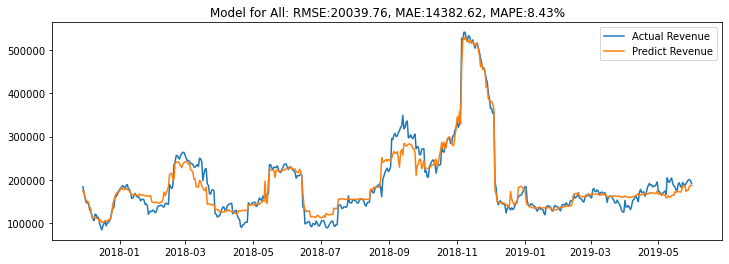

In [25]:
plot_ts('all')

## Production
The whole flask app is containerized in a Docker image. Let's try to make a prediction from docker through the API. 

In [9]:
# !docker run -p 5000:8080 revenue-forecast

In [16]:
port = 5000
query_data = ('all','2018','01','05')
request_json = {'query':query_data,'type':'dict','mode':'test'}
r = requests.post(f'http://127.0.0.1:{port}/predict',json=request_json)
print(literal_eval(r.text))

[175338.53012702998]


To simulate production when new data comes in, we will move the new raw file to the training folder, re-train all the models, and have quick look at the model performance.

In [20]:
new_data_dir = os.path.join('data','cs-production')
for file in glob.glob(os.path.join(new_data_dir,'*.json')):
    shutil.copy(file, data_dir)
# purge the ts-data file so ingestor can produce new ones
try: shutil.rmtree(os.path.join('data','cs-train','ts-data'))
except: pass

In [23]:
from model import update_version
update_version()

In [21]:
model_train(data_dir)

... processing data for loading
... start training
... saving model: models\sl-all-0_2.joblib
... saving model: models\sl-united_kingdom-0_2.joblib
... saving model: models\sl-eire-0_2.joblib
... saving model: models\sl-germany-0_2.joblib
... saving model: models\sl-france-0_2.joblib
... saving model: models\sl-norway-0_2.joblib
... saving model: models\sl-singapore-0_2.joblib
... saving model: models\sl-hong_kong-0_2.joblib
... saving model: models\sl-spain-0_2.joblib
... saving model: models\sl-portugal-0_2.joblib
... saving model: models\sl-netherlands-0_2.joblib


In [5]:
from model import model_load
all_data_new, all_models_new = model_load(save_pickle=True)

... loading ts data from files
Pickle file saved.


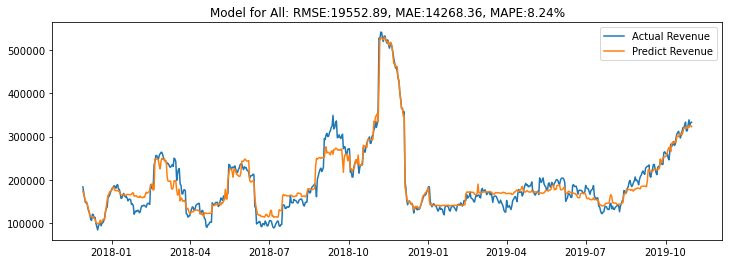

In [7]:
plot_ts('all')